Módulo 5 - Caso prático
========================================================

Professor: Marcos Cesar Gritti  
Email: cesargritti@gmail.com

Antes de começar:
 - Crie uma cópia deste notebook, e o renomeie para "aula_1_modulo_5_{seu_nome}";
 - Caso seu ambiente Anaconda não possua uma das dependências necessárias para a execução do código contigo neste notebook, abra uma célula e execute o comando: ```!pip install -r ../requirements.txt```

Neste módulo vamos aprender sobre:
 1. **Web scraping**;
 2. **Tratamento de retorno utilizando expressões regulares (regex)**;
 3. **Clusterização;**
 4. **Redução de dimensionalidade**;
 
 regex -> Expressão regular (Regular Expression)

Primeiramente, vamos importar as bibliotecas que utilizaremos no estudo de hoje

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from time import sleep

sns.set(rc={"figure.figsize": (14, 6)}, font_scale=1.25)

1 - Web scraping
==============

Na aula de hoje, vamos aprender a coletar dados da internet utilizando a biblioteca ``requests``, diretamente do notebook. Trabalharemos com uma base de fundos imobiliários, disponíveis no website da [Funds Explorer](https://www.fundsexplorer.com.br).

O caso de hoje é um caso simples de scraping, onde trataremos o retorno ``html`` dos website em questão, para extraír informações pertinentes.

A função ``get``da biblioteca ``requests`` realiza o acesso à uma página. Pense nela como uma simulação de acesso via navegador.

**Observações**:
 - Alguns websites, que utilizam novos **frameworks** de front-end, podem não retornar o resultado esperado quando utilizamos a biblioteca ``requests`` para extrair as informações. Nestes casos, para os interessados, sugiro ler sobre o projeto [Selenium](https://selenium-python.readthedocs.io/) e/ou sobre o projeto [Puppeteer](https://pptr.dev/), os quais utilizam os **drivers** originais de um navegador de sua preferência para acessar o site desejado.
 - É uma boa prática de **scraping** modificar o *cabeçalho* (**header**) das requisições feita à um website alvo, de modo a sugerir que o **agente** de pesquisa é um navegador publicamente distribuído por uma empresa de confiança. Isso pode evitar eventuais bloqueios de acesso. Além disso, não devemos abusar no número de requisições simultâneas à um domínio público, o que pode causar instabilidade no servidor de recepção. Para garantir que não geraremos problemas ao Funds Explorer (ou qualquer outra fonte de informação que deseja-se raspar da web), devemos limitar o número de requisições utilizando a função `sleep` do pacote `time`.

In [4]:
# Definindo uma string com alguns user-agents conhecidos pelos servidores web, para evitar possível
# bloqueio durante o acesso.
user_agent = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) "
              "AppleWebKit/537.36 (KHTML, like Gecko) "
              "Chrome/39.0.2171.95 "
              "Safari/537.36")

# Definindo os cabeçalhos que enviaremos junto com a requisição GET
headers = {
    "User-Agent": user_agent
}

In [5]:
# Utilizando a biblioteca requests para emitir uma requisição HTTP com o método GET
# ao website da fundsexplorer
main_response = requests.get("https://www.fundsexplorer.com.br/funds", headers=headers)

2 - Tratamento de retorno utilizando expressões regulares (regex)
=====================================================

O objeto ``main_response``, inicializado na célula anterior, contém o resultado da comunicação com
o servidor web da Funds Explorer. O problema é que, no mundo web, toda comunicação é realizada seguindo
o a linguagem de marcação **HTML**. Precisamos extraír, deste documento **HTML** retornado como ``string``,
as informações desejadas. Estas informações seguem padrões **regulares** (listas, tabelas, etc ...), e para
identificá-las / extraí-las, utilizaremos a biblioteca ``re`` (**Regular Expression**), nativa da linguagem
**Python**.

O conteúdo em texto da requisição que realizamos na célula anterior pode ser acessado por meio da propriedade
``text``. Estamos procurando, no **HTML** retornado, por links que seguem o seguinte padrão:

    <a href="/funds/{nome_do_fundo}">
    
Para extraír os nomes dos fundos dos links, podemos utilizar a seguinte expressão regular:

    <a href=\"/funds/(\w+)\">
    
onde ``(\w+)``, em expressão regular, simboliza um grupo de caracteres alfa-numéricos. 

In [13]:
funds = re.findall("<a href=\"/funds/(\w+)\">", main_response.text)
funds[:5]

['abcp11', 'afcr11', 'afhi11', 'afof11', 'aiec11']

In [15]:
def get_fund_values(fund):
    response = requests.get(f"https://www.fundsexplorer.com.br/funds/{fund}", 
                            headers=headers)
    return re.findall("<span class=\"indicator-value\">\s+(.+)", response.text)

abcp11 = get_fund_values("abcp11")

['2.291', 'R$ 0,53', '0,71%', 'R$ 1,1 bi', 'R$ 88,42', '8,61%', '0,83']

In [18]:
scraped = []
for i, fund in enumerate(funds):
    if (i + 1) % 10 == 0 or i == 0 or (i + 1) == len(funds):
        print(f"Raspando o fundo {fund} ({i+1}/{len(funds)}, {100 * (i+1)/ len(funds):.2f}% concluído)")
    values = get_fund_values(fund)
    scraped.append([fund, *values])
    sleep(0.2)

scraped[0]

Raspando o fundo abcp11 (1/314, 0.32% concluído)
Raspando o fundo arct11 (10/314, 3.18% concluído)
Raspando o fundo bbpo11 (20/314, 6.37% concluído)
Raspando o fundo blmo11 (30/314, 9.55% concluído)
Raspando o fundo brev11 (40/314, 12.74% concluído)
Raspando o fundo btsg11 (50/314, 15.92% concluído)
Raspando o fundo corm11 (60/314, 19.11% concluído)
Raspando o fundo deva11 (70/314, 22.29% concluído)
Raspando o fundo ercr11 (80/314, 25.48% concluído)
Raspando o fundo figs11 (90/314, 28.66% concluído)
Raspando o fundo foft11 (100/314, 31.85% concluído)
Raspando o fundo grlv11 (110/314, 35.03% concluído)
Raspando o fundo hcst11 (120/314, 38.22% concluído)
Raspando o fundo hgru11 (130/314, 41.40% concluído)
Raspando o fundo hsre11 (140/314, 44.59% concluído)
Raspando o fundo jsaf11 (150/314, 47.77% concluído)
Raspando o fundo knri11 (160/314, 50.96% concluído)
Raspando o fundo mcci11 (170/314, 54.14% concluído)
Raspando o fundo mglg11 (180/314, 57.32% concluído)
Raspando o fundo nslu11 (19

['abcp11',
 '2.291',
 'R$ 0,53',
 '0,71%',
 'R$ 1,1 bi',
 'R$ 88,42',
 '8,61%',
 '0,83']

In [22]:
scraped[:2]

[['abcp11',
  '2.291',
  'R$ 0,53',
  '0,71%',
  'R$ 1,1 bi',
  'R$ 88,42',
  '8,61%',
  '0,83'],
 ['afcr11',
  '1.750',
  'R$ 1,10',
  '1,02%',
  'R$ 121,3 mi',
  'R$ 102,14',
  '-1,74%',
  '1,04']]

In [23]:
dados_brutos = pd.DataFrame(scraped, columns=[
    "fundo", "liq_diaria", "ultimo_rend",
    "div_yield", "pat_liq", "val_pat",
    "rent_mes", "pvp"
])

dados_brutos

,fundo,liq_diaria,ultimo_rend,div_yield,pat_liq,val_pat,rent_mes,pvp
0,abcp11,2.291,"R$ 0,53","0,71%","R$ 1,1 bi","R$ 88,42","8,61%","0,83"
1,afcr11,1.750,"R$ 1,10","1,02%","R$ 121,3 mi","R$ 102,14","-1,74%","1,04"
2,afhi11,7.410,"R$ 0,90","0,94%",R$ 173 mi,"R$ 96,75","1,33%","0,98"
3,afof11,816,"R$ 0,60","8,76%","R$ 69,7 mi","R$ 100,77","8,76%","0,94"
4,aiec11,2.015,"R$ 0,61","0,71%","R$ 484,1 mi","R$ 100,33","5,40%","0,80"
...,...,...,...,...,...,...,...,...
309,xppr11,19.974,"R$ 0,55","0,77%","R$ 626,4 mi","R$ 85,62","9,17%","0,80"
310,xpsf11,13.179,"R$ 0,70","0,74%","R$ 409,3 mi","R$ 94,53","1,70%","0,89"
311,xted11,1.938,"R$ 0,00","0,00%","R$ 25,8 mi","R$ 13,93","1,10%","0,49"
312,ychy11,65,"R$ 19,41","1,94%","R$ 23,1 mi","R$ 989,04","-6,48%","1,01"


In [61]:
def format_values(value):
    return (re.sub("(R\$ |%|\.)", "", value)
              .replace(",", ".")
              .replace(" mi", "e6")
              .replace(" bi", "e9"))

dados = dados_brutos.applymap(format_values, "ignore")
dados.iloc[:, 1:] = dados.iloc[:, 1:].replace("N/A", np.nan).astype(float)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fundo        314 non-null    object
 1   liq_diaria   281 non-null    object
 2   ultimo_rend  288 non-null    object
 3   div_yield    275 non-null    object
 4   pat_liq      307 non-null    object
 5   val_pat      307 non-null    object
 6   rent_mes     278 non-null    object
 7   pvp          281 non-null    object
dtypes: object(8)
memory usage: 19.8+ KB


In [53]:
df = dados.replace(np.inf, np.nan).dropna().reset_index(drop=True)
df

,fundo,liq_diaria,ultimo_rend,div_yield,pat_liq,val_pat,rent_mes,pvp
0,abcp11,2291.0,0.53,0.71,1.100000e+09,88.42,8.61,0.83
1,afcr11,1750.0,1.10,1.02,1.213000e+08,102.14,-1.74,1.04
2,afhi11,7410.0,0.90,0.94,1.730000e+08,96.75,1.33,0.98
3,afof11,816.0,0.60,8.76,6.970000e+07,100.77,8.76,0.94
4,aiec11,2015.0,0.61,0.71,4.841000e+08,100.33,5.40,0.80
...,...,...,...,...,...,...,...,...
253,xpml11,52855.0,0.52,0.48,1.900000e+09,104.85,2.44,0.97
254,xppr11,19974.0,0.55,0.77,6.264000e+08,85.62,9.17,0.80
255,xpsf11,13179.0,0.70,0.74,4.093000e+08,94.53,1.70,0.89
256,xted11,1938.0,0.00,0.00,2.580000e+07,13.93,1.10,0.49


<AxesSubplot:xlabel='pat_liq', ylabel='Count'>

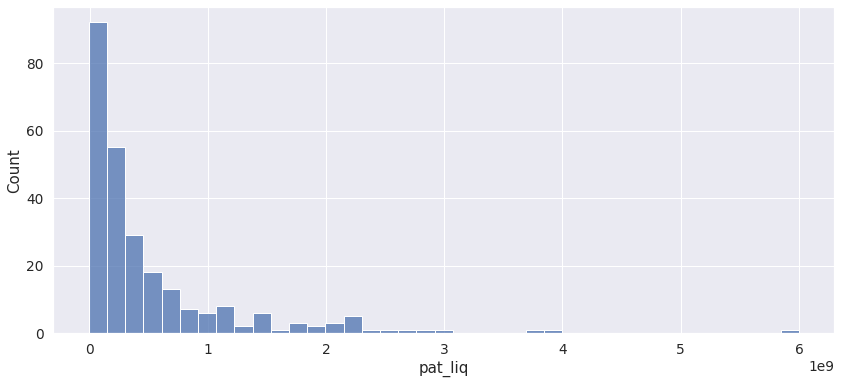

In [14]:
sns.histplot(data=df, x="pat_liq")

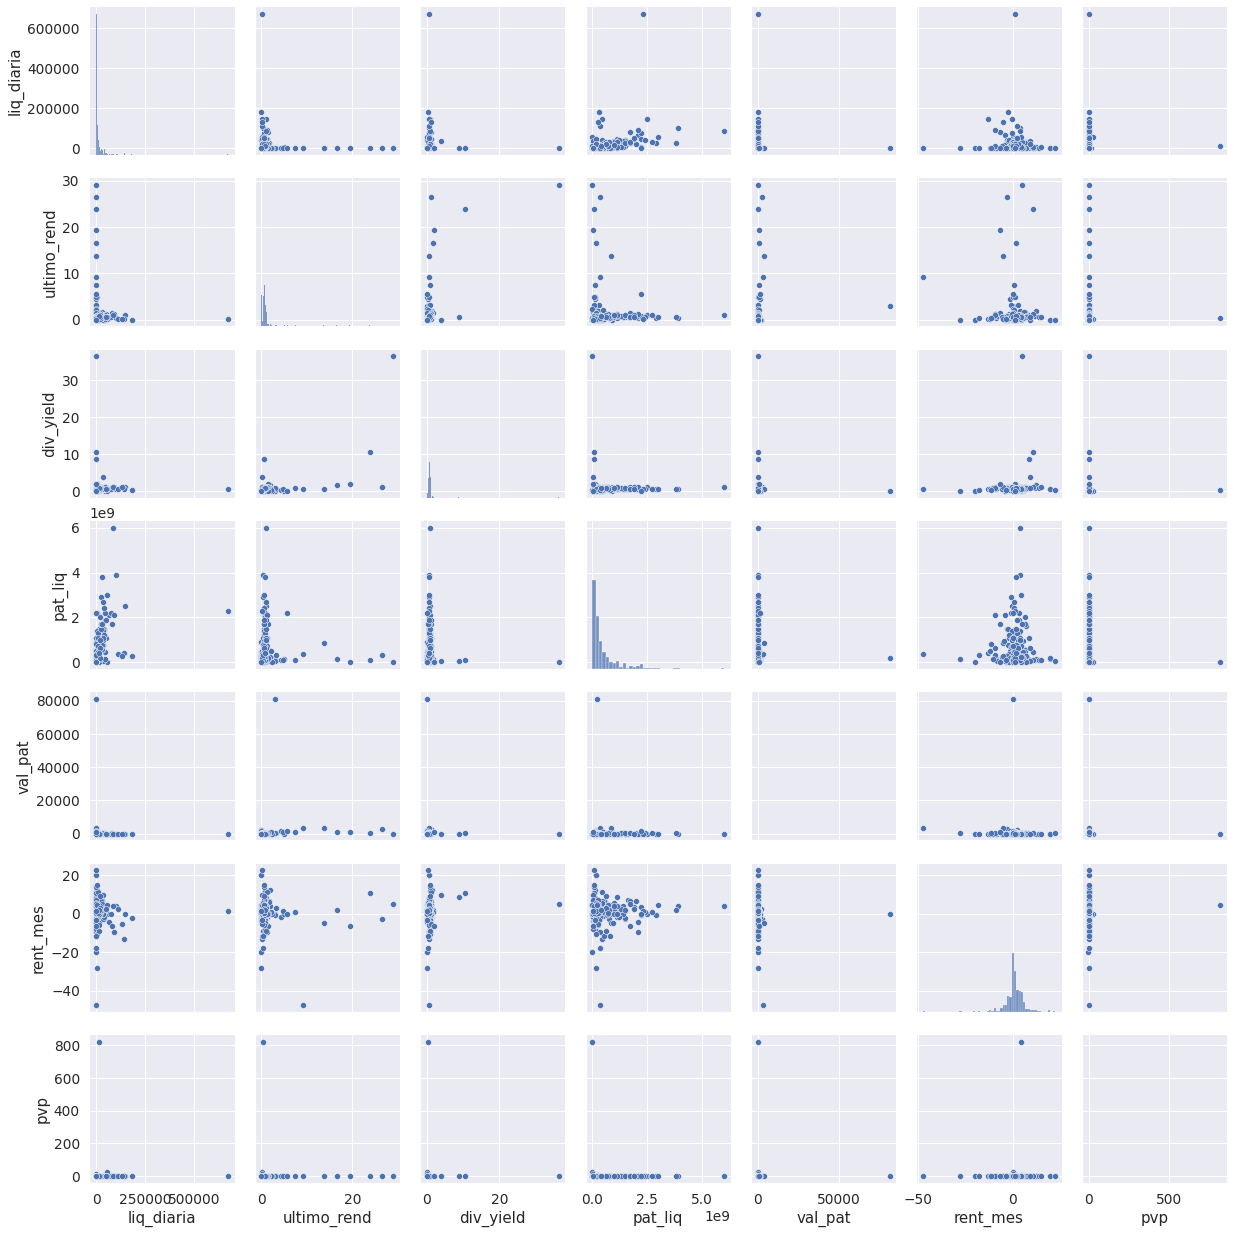

In [15]:
sns.pairplot(df)

3 - Clusterização
==============

In [65]:
scaler = StandardScaler() # Padronizador de variáveis (Média zero, desvio padrão 1)
X = df.select_dtypes(float)
X = scaler.fit_transform(X)

clusterer = DBSCAN(eps=0.5, min_samples=3) # Density-based spatial clustering of applications with noise
labels = clusterer.fit_predict(X)

df["cluster"] = labels

from collections import Counter

Counter(labels)

Counter({-1: 36, 0: 205, 1: 4, 2: 3, 3: 4, 4: 3, 5: 3})

In [68]:
df.query("cluster in (1, 2)")

,fundo,liq_diaria,ultimo_rend,div_yield,pat_liq,val_pat,rent_mes,pvp,cluster
9,arri11,1997.0,0.87,0.76,101500000.0,96.79,11.94,1.03,1
16,bbvj11,763.0,0.00,0.61,155000000.0,57.18,19.96,1.10,2
42,cjct11,20.0,0.00,0.61,182200000.0,67.23,19.96,0.86,2
78,fmof11,4.0,0.03,0.25,67000000.0,131.92,22.40,0.51,2
79,foft11,5663.0,1.90,1.54,125600000.0,104.98,12.26,1.17,1
195,rdpd11,4.0,0.62,0.89,76700000.0,71.18,13.90,0.99,1
218,sptw11,7249.0,0.60,0.97,93600000.0,52.08,15.06,1.10,1


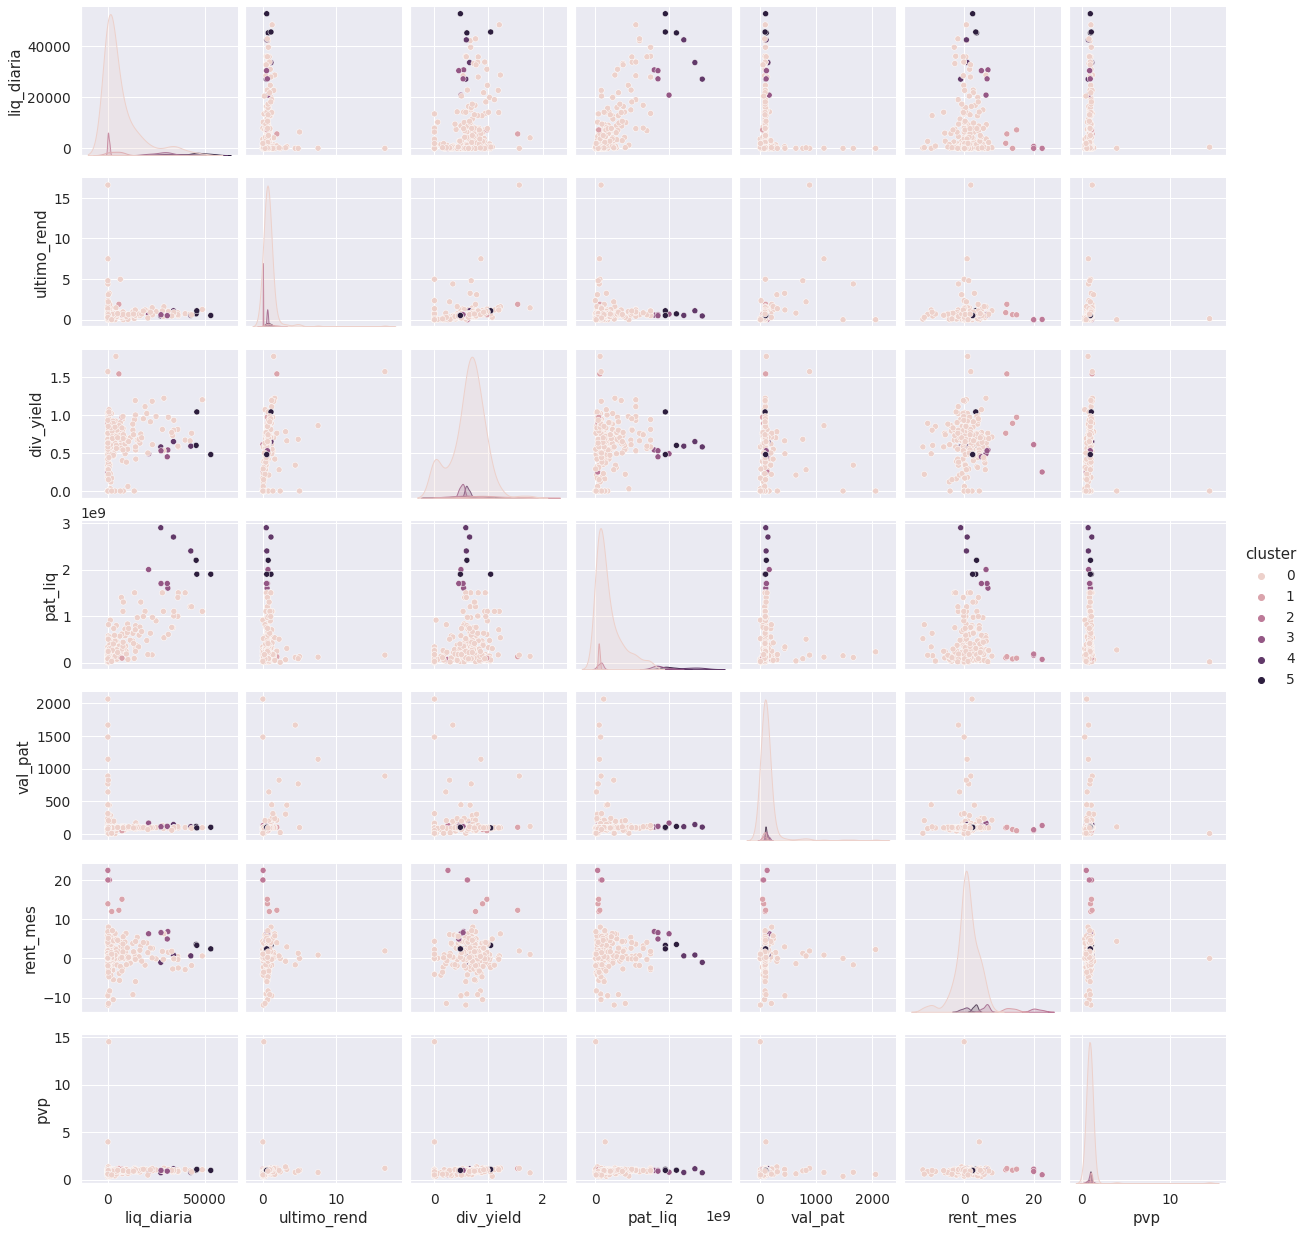

In [69]:
sns.pairplot(data=df.query("cluster != -1"), hue="cluster")

4 - Redução de dimensionalidade
===========================

In [70]:
pca = PCA(n_components=2) # Principal Component Analysis (SVD), Auto-Encoders
Z = pca.fit_transform(X) # O mesmo número de linhas, mas apenas 2 colunas

df["pc1"] = Z[:, 0]
df["pc2"] = Z[:, 1]
df

,fundo,liq_diaria,ultimo_rend,div_yield,pat_liq,val_pat,rent_mes,pvp,cluster,pc1,pc2
0,abcp11,2291.0,0.53,0.71,1.100000e+09,88.42,8.61,0.83,-1,-0.186735,0.261950
1,afcr11,1750.0,1.10,1.02,1.213000e+08,102.14,-1.74,1.04,0,-0.034107,-0.554178
2,afhi11,7410.0,0.90,0.94,1.730000e+08,96.75,1.33,0.98,0,-0.065817,-0.457094
3,afof11,816.0,0.60,8.76,6.970000e+07,100.77,8.76,0.94,-1,-0.115024,-1.145098
4,aiec11,2015.0,0.61,0.71,4.841000e+08,100.33,5.40,0.80,0,-0.111556,-0.280079
...,...,...,...,...,...,...,...,...,...,...,...
253,xpml11,52855.0,0.52,0.48,1.900000e+09,104.85,2.44,0.97,5,-0.283433,1.824388
254,xppr11,19974.0,0.55,0.77,6.264000e+08,85.62,9.17,0.80,-1,-0.170516,0.063046
255,xpsf11,13179.0,0.70,0.74,4.093000e+08,94.53,1.70,0.89,0,-0.098142,-0.146903
256,xted11,1938.0,0.00,0.00,2.580000e+07,13.93,1.10,0.49,0,-0.064699,-0.623064


In [19]:
df.query("cluster != -1")

,fundo,liq_diaria,ultimo_rend,div_yield,pat_liq,val_pat,rent_mes,pvp,cluster,pc1,pc2
1,afcr11,1750.0,1.10,1.02,121300000.0,102.14,-1.74,1.04,0,0.202043,-0.520893
2,afhi11,7410.0,0.90,0.94,173000000.0,96.75,1.33,0.98,0,0.112792,-0.417879
4,aiec11,2015.0,0.61,0.71,484100000.0,100.33,5.40,0.80,0,-0.062502,-0.260571
6,alzr11,8865.0,0.62,0.49,575900000.0,108.06,6.18,1.07,0,-0.182982,-0.111726
7,aqll11,1.0,0.00,0.00,145500000.0,1481.39,0.00,0.34,0,-0.263158,-0.733618
...,...,...,...,...,...,...,...,...,...,...,...
247,wtsp11b,5.0,0.29,0.63,79000000.0,79.61,0.09,0.58,0,-0.029128,-0.679330
248,xpci11,21850.0,0.93,0.91,630000000.0,95.94,2.63,1.03,0,-0.114861,0.178977
251,xpin11,10651.0,0.64,0.65,734400000.0,111.51,0.28,0.86,0,-0.236342,0.065203
255,xpsf11,13179.0,0.70,0.74,409300000.0,94.53,1.70,0.89,0,-0.090965,-0.168766


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

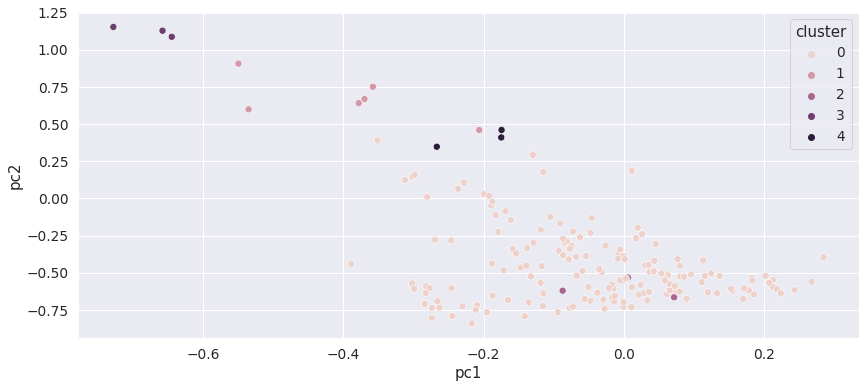

In [20]:
sns.scatterplot(data=df.query("cluster != -1"), x="pc1", y="pc2", hue="cluster", s=50)